## Heart Disease Detection Project:
### A classification Problem

The dataset and project idea have been taken from [YouTube (Siddhardhan)](https://www.youtube.com/watch?v=qmqCYC-MBQo&list=PLfFghEzKVmjvuSA67LszN1dZ-Dd_pkus6&index=9), where only logistic regression was used. 

In this project, I decided to work on the same dataset, aiming to achieve better accuracy and overall results. Additionally, I have implemented a web interface for the project using Streamlit and deployed it successfully.

Credit for the project idea and dataset goes to the original owner. The initial project had an accuracy of 81%. In our project, we will use different algorithms, evaluate them, and select the best among them to achieve better results.


#### 1) Importing the necessary Libraries

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

#### 2) Data Collection and Preprocessing

In [116]:
# loading the csv data to a Pandas DataFrame
file_path = 'heart_disease_data.csv'
heart_df = pd.read_csv(file_path)

In [117]:
# print first 5 rows of the dataset
heart_df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [118]:
# number of rows and columns in the dataset
heart_df.shape

(303, 14)

In [119]:
#checking if there any columns with null values
heart_df.columns[heart_df.isnull().any()]

Index([], dtype='object')

- Our Dataset does not contain any NULL values so we are good to go with further pre processing of Data

In [120]:
# getting some info about the data
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


- The information regarding our dataset looks ok with required the datatypes

In [121]:
# statistical measures about the data
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [122]:
# checking the distribution of Target Variable
heart_df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

1 --> Defective Heart

0 --> Healthy Heart

- Based on the description of our dataset we are not required to perform any Encoding, also the dataset is well enough balanced

In [123]:
# Splitting the Data into Depandant and Indepandant Variables
X = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

#### 3) Defininig The Models:

In [124]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", max_depth=2),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

#### 4)Using k-Fold For Best Model Selection:

In [125]:
# Number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    aucs = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Fit the scaler on the training data and transform both the training and test data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_prob))

    # Store results for each model
    results[name] = {
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1 Score': np.mean(f1s),
        'AUC': np.mean(aucs)
    }

#### 5) Checking the scores for different Models

In [126]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T

results_df


,Accuracy,Precision,Recall,F1 Score,AUC
Logistic Regression,0.821585,0.811986,0.884745,0.845151,0.899861
Support Vector Classifier,0.838087,0.835145,0.884354,0.856605,0.893440
K-Nearest Neighbors,0.837978,0.830788,0.896665,0.859184,0.891267
Decision Tree,0.709672,0.698310,0.870432,0.764188,0.818921
Gaussian Naive Bayes,0.808142,0.820010,0.841163,0.828544,0.892448
Random Forest,0.805082,0.809986,0.850777,0.827397,0.897824


#### 6) Visualizing the above results

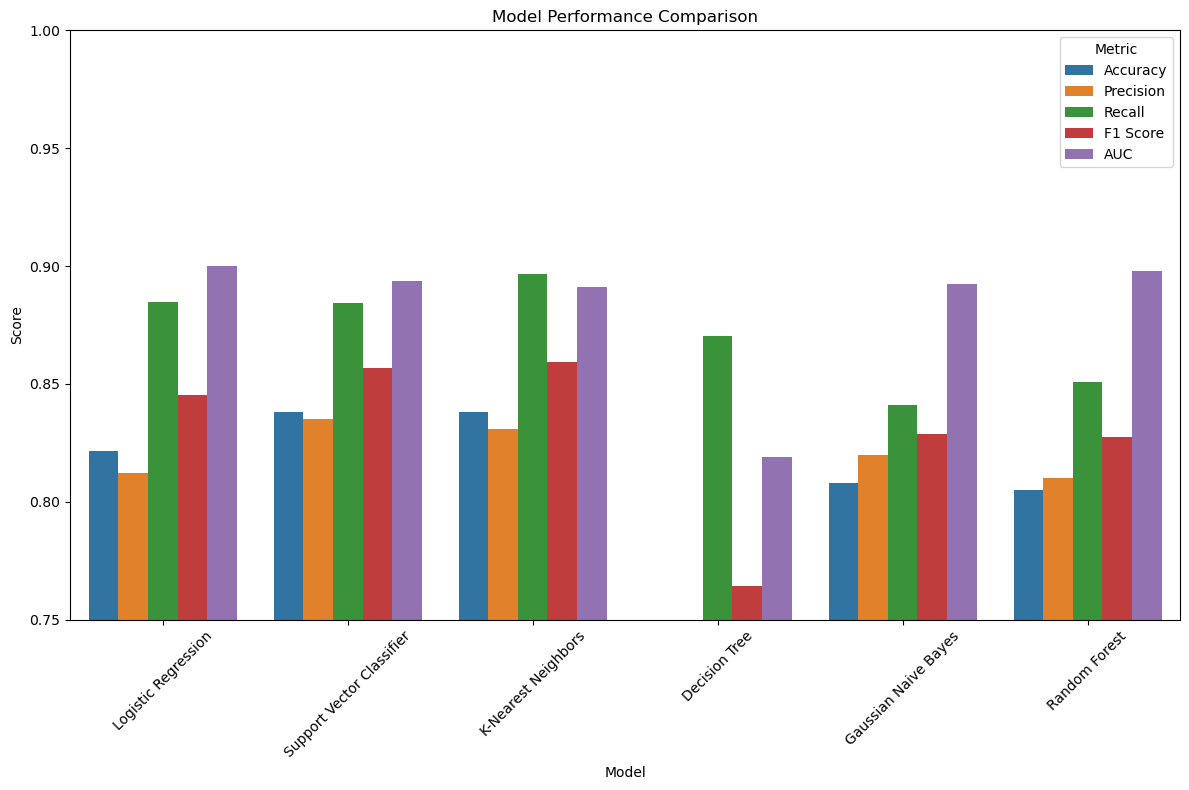

In [127]:
# Convert the results dictionary to a DataFrame and add a 'Model' column
results_df = pd.DataFrame(results).T
results_df.reset_index(inplace=True)
results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Melt the DataFrame to have a long-form DataFrame suitable for seaborn
results_df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 8))
sns.barplot(data=results_df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Adjust y-axis limits to zoom in on differences
plt.ylim(0.75, 1)  # Example range; adjust based on your data

plt.tight_layout()
plt.show()


- Based on above data we select the Support Vector Classifier or KNN Models for this Project , Now in next part we will train the model also tune its parameters to get better results if possible , also we will Deploy the Model With UI using Streamlit.

- In Final Model Selection Notebook we will decide which one to choose from among SVC and KNN